<div style="text-align: center; margin-bottom: 20px;">

  <div style="font-size: 2em; font-weight: bold;">🎙️ Audio Command Recognition Using MFCC
 Features and SVM Classification</div>
  <div style="font-size: 1.5em;">Simple AI model to recognize 'Yes' or 'No' from audio commands</div>
  <div style="font-size: 1.2em; font-weight: bold;">by Fares Hazem</div>

</div>

# 1. Setup
## 🚀 Import Libraries & Set Seed 🎲

In [1]:
import os
import random
import shutil
from pathlib import Path
import numpy as np
import librosa
import librosa.display
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from IPython.display import FileLink, Audio

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

# 2. Data Preparation
## 📥 Download & Extract Dataset  

In [2]:
# Download the Speech Commands dataset quietly and save it to the working directory
!wget -q http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz -O /kaggle/working/speech_commands_v0.02.tar.gz

# Extract the downloaded tar.gz file into the working directory
!tar -xzf /kaggle/working/speech_commands_v0.02.tar.gz -C /kaggle/working

## 📂 Prepare Balanced Subset  

In [3]:
base_dir = Path('/kaggle/working')
src_yes = base_dir / 'speech_commands' / 'yes'
src_no  = base_dir / 'speech_commands' / 'no'

# Handle possible variations in extraction path of dataset
if not src_yes.exists() or not src_no.exists():
    alt = base_dir
    src_yes = alt / 'yes'
    src_no  = alt / 'no'
    if not src_yes.exists() or not src_no.exists():
        print("Can't find 'yes'/'no' folders. List top-level contents:")
        print(sorted([p.name for p in base_dir.iterdir() if p.exists()]))
        raise SystemExit("Check dataset extraction path or enable internet in Kaggle.")

# Destination folders for balanced dataset subset
dest = base_dir / 'data' / 'yes_no'
(dest / 'yes').mkdir(parents=True, exist_ok=True)
(dest / 'no').mkdir(parents=True, exist_ok=True)

def copy_all_files(src_folder, dest_folder):
    # Copy all .wav files from source to destination folder
    files = [f for f in os.listdir(src_folder) if f.endswith('.wav')]
    for fname in files:
        shutil.copy(src_folder / fname, dest_folder / fname)
    return len(files)

# Copy files and count how many copied for each label
n_yes = copy_all_files(src_yes, dest / 'yes')
n_no = copy_all_files(src_no, dest / 'no')

print(f"Copied {n_yes} 'yes' files and {n_no} 'no' files to {dest}")

# Show a few sample files for verification
print("Sample files (first 5 yes):", sorted(os.listdir(dest / 'yes'))[:5])
print("Sample files (first 5 no):", sorted(os.listdir(dest / 'no'))[:5])

Copied 4044 'yes' files and 3941 'no' files to /kaggle/working/data/yes_no
Sample files (first 5 yes): ['004ae714_nohash_0.wav', '004ae714_nohash_1.wav', '00970ce1_nohash_0.wav', '00f0204f_nohash_0.wav', '00f0204f_nohash_1.wav']
Sample files (first 5 no): ['012c8314_nohash_0.wav', '0132a06d_nohash_0.wav', '0132a06d_nohash_1.wav', '0132a06d_nohash_2.wav', '0132a06d_nohash_3.wav']


## 🎶 Extract & Save MFCC Features

In [4]:
base = Path('/kaggle/working/data/yes_no')
classes = ['yes', 'no']
sr = 16000                      # Target sampling rate
duration = 1.0                  # Seconds (speech_commands audio ~1s)
max_len = int(sr * duration)
n_mfcc = 13                     # Number of MFCC coefficients

X = []
y = []
files_used = []

def extract_features(path):
    """
    Load audio, pad/trim to fixed length, extract MFCC features,
    summarize with mean and std deviation for each coefficient.
    """
    wav, _ = librosa.load(path, sr=sr)
    if len(wav) < max_len:
        wav = np.pad(wav, (0, max_len - len(wav)))
    else:
        wav = wav[:max_len]
    
    mf = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    mf_mean = mf.mean(axis=1)
    mf_std  = mf.std(axis=1)
    feat = np.concatenate([mf_mean, mf_std])
    return feat

# Extract features for all files in each class
for cls in classes:
    folder = base / cls
    if not folder.exists():
        raise FileNotFoundError(f"Missing folder: {folder}")
    wavs = sorted([p for p in folder.iterdir() if p.suffix == '.wav'])
    if len(wavs) == 0:
        raise RuntimeError(f"No .wav files found in {folder}")
    
    for p in tqdm(wavs, desc=f"Processing {cls}", leave=True):
        try:
            feat = extract_features(str(p))
            X.append(feat)
            y.append(cls)
            files_used.append(str(p))
        except Exception as e:
            print("Error processing", p, e)

# Convert features list to numpy array
X = np.vstack(X)

# Encode labels as integers (0,1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

print("X shape:", X.shape)
print("Labels:", le.classes_, " -> encoded as", np.unique(y_enc))
print("Example feature vector (first file):", X[0][:6])

# Save extracted features, labels, and file paths for later use
out_dir = Path('/kaggle/working/processed')
out_dir.mkdir(parents=True, exist_ok=True)
np.save(out_dir / 'X.npy', X)
np.save(out_dir / 'y.npy', y_enc)
np.save(out_dir / 'files.npy', np.array(files_used))

# Save label mapping to JSON
with open(out_dir / 'label_map.json', 'w') as f:
    json.dump({'classes': le.classes_.tolist()}, f)

print("Saved X.npy, y.npy, files.npy and label_map.json to", out_dir)

Processing yes:   0%|          | 0/4044 [00:00<?, ?it/s]

Processing no:   0%|          | 0/3941 [00:00<?, ?it/s]

X shape: (7985, 26)
Labels: ['no' 'yes']  -> encoded as [0 1]
Example feature vector (first file): [-404.91022   -15.788225   -6.964138   51.332047  -29.858429   30.293385]
Saved X.npy, y.npy, files.npy and label_map.json to /kaggle/working/processed


# 3. Modeling
## 🧪 Load Data & Train/Test Split  

In [5]:
# Load saved MFCC features and labels
data_dir = Path('/kaggle/working/processed')
X = np.load(data_dir / 'X.npy')
y = np.load(data_dir / 'y.npy')

# Load label mapping to interpret encoded classes
with open(data_dir / 'label_map.json') as f:
    label_map = json.load(f)
classes = label_map['classes']

print("Loaded feature and label shapes:", X.shape, y.shape)
print("Classes:", classes)

Loaded feature and label shapes: (7985, 26) (7985,)
Classes: ['no', 'yes']


## 🔀 Balanced Split 

In [6]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (6388, 26) Test size: (1597, 26)


## 🏋️ Train SVM Model

In [7]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

## 📝 Testing & Classification Report 

In [17]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\nAccuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=classes))


Accuracy: 0.9242329367564183

Classification Report:
               precision    recall  f1-score   support

          no       0.92      0.93      0.92       788
         yes       0.93      0.92      0.92       809

    accuracy                           0.92      1597
   macro avg       0.92      0.92      0.92      1597
weighted avg       0.92      0.92      0.92      1597



# 4. Evaluation
## 📊 Confusion Matrix  

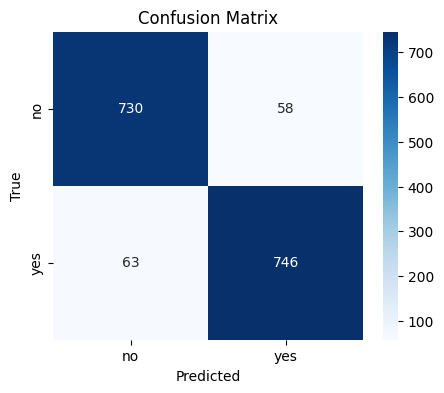

/kaggle/working/confusion_matrix.png

In [18]:
# Predict on test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with labels
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.savefig("confusion_matrix.png")
plt.show()

# Provide clickable link to download confusion matrix image
FileLink(r'confusion_matrix.png')

## 📈 ROC & AUC Calculation  

In [19]:
data_dir = Path('/kaggle/working/processed')

# Get probability scores for positive class ("yes")
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print("AUC Score:", roc_auc)

AUC Score: 0.9777589365827336


## 🎨 Plot ROC Curve  

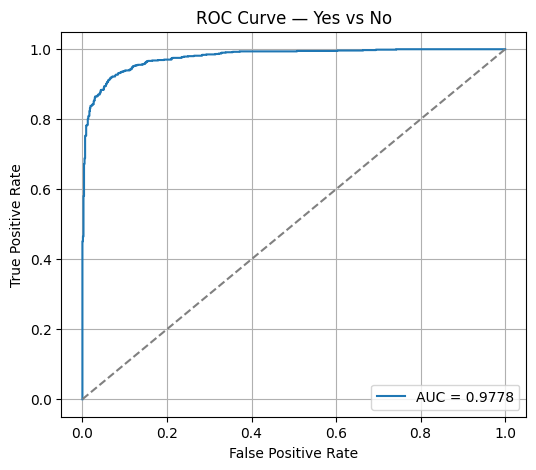

/kaggle/working/roc_curve.png

In [29]:
# Plot ROC curve with AUC value in legend
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Yes vs No")
plt.legend()
plt.grid(True)

plt.savefig("roc_curve.png")
plt.show()

# Provide clickable link to download confusion matrix image
FileLink(r'roc_curve.png')

## 💾 Save Model & Download Link

In [21]:
# Define path to save the trained SVM model
model_path = data_dir / "svm_yes_no_model.pkl"

# Save the model to disk
joblib.dump(model, model_path)

print("Model saved to:", model_path)

# Provide a clickable link to download the saved model file
FileLink(model_path)

Model saved to: /kaggle/working/processed/svm_yes_no_model.pkl


/kaggle/working/processed/svm_yes_no_model.pkl

# 5. Prediction
## 🎤 Load Model & Predict Audio  

In [22]:
# Load the trained SVM model

model_path = Path("/kaggle/working/processed/svm_yes_no_model.pkl")
model = joblib.load(model_path)

# Load label classes for decoding predictions
with open("/kaggle/working/processed/label_map.json") as f:
    classes = json.load(f)["classes"]

def extract_features(path):
    """
    Load audio file, pad/trim to fixed length,
    extract MFCC features, and summarize with mean and std.
    """
    wav, _ = librosa.load(path, sr=sr)
    if len(wav) < max_len:
        wav = np.pad(wav, (0, max_len - len(wav)))
    else:
        wav = wav[:max_len]

    mf = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    mf_mean = mf.mean(axis=1)
    mf_std = mf.std(axis=1)
    return np.concatenate([mf_mean, mf_std])

## 🔊 Predict Function  

In [23]:
def predict_audio(wav_path):
    features = extract_features(wav_path).reshape(1, -1)
    pred = model.predict(features)[0]
    prob = model.predict_proba(features)[0]

    print("File:", wav_path)
    print("Prediction:", classes[pred])
    print("Probabilities:")
    for c, p in zip(classes, prob):
        print(f"  {c}: {p:.4f}")

    return classes[pred]

# ▶️ Example Usage:

## 🎧 Audio Playback

In [24]:
# Path to audio file for testing
Yes = "/kaggle/input/yesno/test_yes.wav"
No = "/kaggle/input/yesno/test_no.wav"

# Display an inline audio player for playback
Audio(Yes)

## 📊 Plot Waveform  

/tmp/ipykernel_47/1973345042.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, _ = librosa.load(Yes, sr=16000)


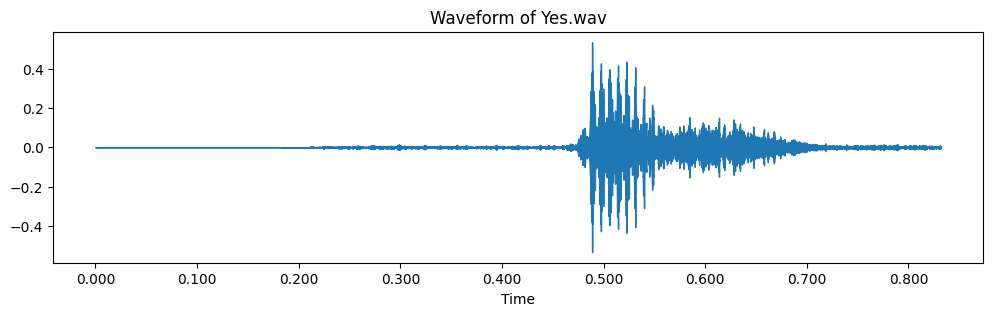

In [27]:
# Load audio file with target sampling rate
wav, _ = librosa.load(Yes, sr=16000)

# Plot waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(wav, sr=16000)
plt.title("Waveform of Yes.wav")
plt.show()

## 🔮 Predict Audio File

In [28]:
# After uploading a .wav file via Kaggle's upload interface,
# call the predict_audio function with the file path:

predict_audio(Yes)

File: /kaggle/input/yesno/Yes-new.wav
Prediction: yes
Probabilities:
  no: 0.0705
  yes: 0.9295


/tmp/ipykernel_47/3168148982.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, _ = librosa.load(path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


'yes'